# Target label definition

Describe the problem.

In [2]:
import pandas as pd
import os
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

import src.modules.label_extraction as le
import src.utils.dataset_helper as db
import src.modules.plotting as p
import importlib

from glob import glob

importlib.reload(le);
importlib.reload(p);
importlib.reload(db);

- `df_fsr`: contains freesurfers information
- `df_cdr`: contains data about subjects' visit from which it is possible to extract the target label

In [2]:
df_fsr = pd.read_csv('../data/csv/OASIS3_Freesurfer_output.csv')
df_cdr = pd.read_csv('../data/csv/OASIS3_UDSb4_cdr.csv')

In [3]:
df_cdr['CDRTOT'].value_counts()

CDRTOT
0.0    6479
0.5    1444
1.0     528
2.0     155
3.0      19
Name: count, dtype: int64

- Remove from `df_fsr` the labels related to empty freesurfers

In [3]:
df_fsr = df_fsr[~df_fsr['MR_session'].isin(os.listdir('../data/empty'))]

- Define a new column in `df_cdr` and `df_fsr` that encapsule the temporal information

In [4]:
df_cdr['time'] = le.get_time_column(df_cdr['OASIS_session_label'])
df_fsr['time'] = le.get_time_column(df_fsr['MR_session'])

- Checking negative time columns for `df_cdr`:

In [5]:
df_cdr[df_cdr['time'] < 0].shape[0]

5

- Checking negative time columns for `df_fsr`:

In [6]:
df_fsr[df_fsr['time'] < 0].shape[0]

0

## Fixing negative time columns

- Clearly OAS30753 is a mistake: the cdr is null for this patient and we can't infer about its possible dementia
- The other ones looks like errors in typing, they will be fixed

In [7]:
df_cdr[df_cdr['time'] < 0]

,OASISID,OASIS_session_label,days_to_visit,age at visit,MMSE,memory,orient,judgment,commun,homehobb,...,dx2_code,dx3_code,dx4_code,dx5_code,dx1,dx2,dx3,dx4,dx5,time
1883,OAS30290,OAS30290_UDSb4_d-0002,-2,47.45,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,No dementia,.,.,.,.,-2
2116,OAS30330,OAS30330_UDSb4_d-0101,-101,80.53,24.0,0.5,0.5,0.0,0.0,0.5,...,NaN,NaN,NaN,NaN,"DLBD, primary",.,.,.,.,-101
2462,OAS30380,OAS30380_UDSb4_d-0015,-15,61.39,28.0,0.5,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,uncertain dementia,Active Other neurol/med diagnoses,.,.,.,-15
4914,OAS30753,OAS30753_UDSb4_d-39520,-39520,-47.25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-39520
5667,OAS30851,OAS30851_UDSb4_d-0001,-1,73.49,NaN,0.5,0.0,0.5,0.5,0.5,...,NaN,NaN,NaN,NaN,"Non DAT, Other primary",.,.,.,.,-1


- Remove the error instance

In [8]:
df_cdr = df_cdr.drop(index=4914)
df_fsr = df_fsr.drop(index=df_fsr[df_fsr['Subject'] == 'OAS30753'].index)

- Fix the column and subject label names

In [9]:
df_cdr[['OASIS_session_label', 'time']] = le.fix_negative_time_label(df_cdr, 'time', 'OASIS_session_label')

- Reindex the columns to prepare the two dataframes for the matchup

In [10]:
df_cdr = le.put_first(df_cdr, ['OASIS_session_label', 'OASISID'])
df_fsr = le.put_first(df_fsr, ['MR_session', 'Subject'])

- Match diagnosis with sessions

In [ ]:
df_matched = le.session_matchup(df_fsr, df_cdr, 365, 365)

In [19]:
df_matched[df_matched['Subject'] == 'OAS30194']

,MR_session,Subject,FS_FSDATA ID,Subject_accession,Freesurfer_accession,FS QC Status,version,IntraCranialVol,lhCortexVol,rhCortexVol,...,dx1_code,dx2_code,dx3_code,dx4_code,dx5_code,dx1,dx2,dx3,dx4,dx5
419,OAS30194_MR_d6605,OAS30194,OAS30194_Freesurfer53_d6605,CENTRAL_S05264,CENTRAL_E09582,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1867645.224,247370.9703,250884.9538,...,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.
420,OAS30194_MR_d7432,OAS30194,OAS30194_Freesurfer53_d7432,CENTRAL_S05264,CENTRAL_E09583,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1887004.159,231825.5768,236693.4273,...,2.0,NaN,NaN,NaN,NaN,uncertain dementia,.,.,.,.
421,OAS30194_MR_d8874,OAS30194,OAS30194_Freesurfer53_d8874,CENTRAL_S05264,CENTRAL_E09584,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1805484.564,224399.0013,228705.1233,...,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.
422,OAS30194_MR_d8881,OAS30194,OAS30194_Freesurfer53_d8881,CENTRAL_S05264,CENTRAL_E09585,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1868551.738,227266.4747,235192.8177,...,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.
423,OAS30194_MR_d9317,OAS30194,OAS30194_Freesurfer53_d9317,CENTRAL_S05264,CENTRAL_E72180,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1859700.161,226547.3211,231920.6494,...,3.0,NaN,NaN,NaN,NaN,AD Dementia,A,A,A,A
424,OAS30194_MR_d9443,OAS30194,OAS30194_Freesurfer53_d9443,CENTRAL_S05264,CENTRAL_E09586,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1827628.723,220620.3655,226473.8596,...,3.0,NaN,NaN,NaN,NaN,AD Dementia,A,A,A,A


In [21]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'OAS30194 after label correction')

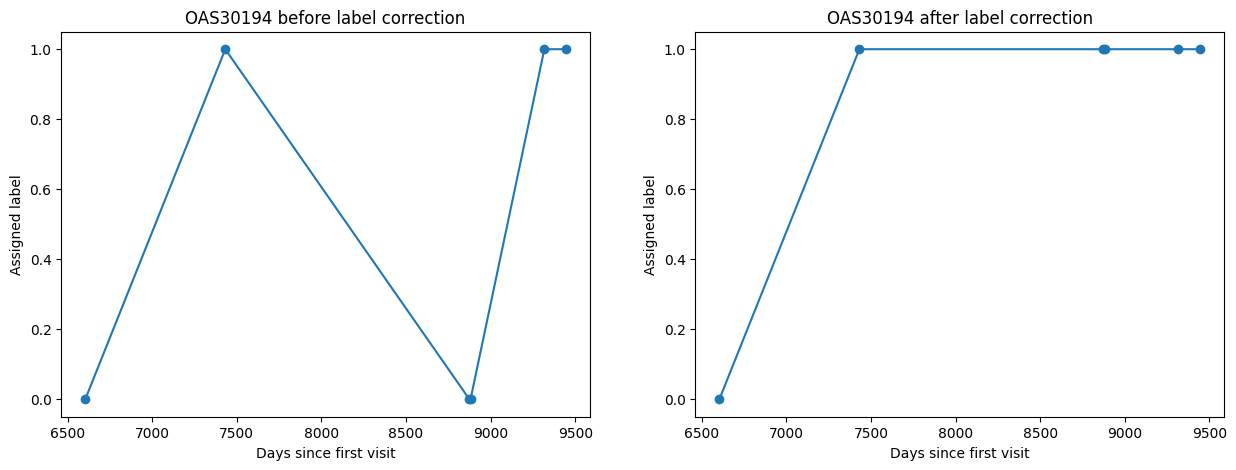

In [41]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()

ax[0].scatter([6605, 7432, 8874, 8881, 9317, 9443], [0, 1, 0, 0, 1, 1])
ax[0].plot([6605, 7432, 8874, 8881, 9317, 9443], [0, 1, 0, 0, 1, 1])
ax[0].set_xlabel(xlabel='Days since first visit')
ax[0].set_ylabel(ylabel='Assigned label')
ax[0].set_title('OAS30194 before label correction')

ax[1].scatter([6605, 7432, 8874, 8881, 9317, 9443], [0, 1, 1, 1, 1, 1])
ax[1].plot([6605, 7432, 8874, 8881, 9317, 9443], [0, 1, 1, 1, 1, 1])
ax[1].set_xlabel(xlabel='Days since first visit')
ax[1].set_ylabel(ylabel='Assigned label')
ax[1].set_title('OAS30194 after label correction')

- Align the cdr values

In [12]:
df_matched['CDRTOT'] = le.align_labels(df_matched, 'Subject', 'CDRTOT')

OAS30040
OAS30139
OAS30161
OAS30173
OAS30181
OAS30185
OAS30194
OAS30206
OAS30208
OAS30241
OAS30342
OAS30369
OAS30418
OAS30445
OAS30452
OAS30466
OAS30596
OAS30597
OAS30612
OAS30667
OAS30810
OAS30867
OAS30978
OAS31037
OAS31043
OAS31046
OAS31111
OAS31127
OAS31128


In [14]:
df_matched['label'] = df_matched['CDRTOT'].map(
    lambda x: 'Cognitevely-normal' if x == 0 else 'Early-stage' if x == .5 else 'Demented'
)

- Perform a final check

In [15]:
f = os.path.join('..', 'data', 'freesurfers')

left_hippo_files = sorted(glob(os.path.join(f, '*', 'mri', '*Left-Hippocampus.mgz')))
right_hippo_files = sorted(glob(os.path.join(f, '*', 'mri', '*Right-Hippocampus.mgz')))

l1 = [s.split("\\")[3] for s in left_hippo_files]
l2 = [s.split("\\")[3] for s in right_hippo_files]

print(f"The number of elements NOT in common is: {set.difference(set(l1), set(l2))}")

The number of elements NOT in common is: set()


In [16]:
df_matched[[
    'Subject', 'MR_session', 'TOTAL_HIPPOCAMPUS_VOLUME', 'Left-Hippocampus_volume', 
    'lh_parahippocampal_thickness', 'lh_parahippocampal_volume', 'rh_parahippocampal_volume',
    'rh_parahippocampal_thickness', 'Right-Hippocampus_volume', 'label', 'CDRTOT',
]].to_csv('../data/csv/final_dataset.csv')

In [3]:
df = pd.read_csv('../data/csv/final_dataset.csv')

In [5]:
df['label'].value_counts()

label
Cognitevely-normal    1892
Early-stage            368
Demented               119
Name: count, dtype: int64

## Undersample majority class

- Class distribution before resample

In [4]:
helper = db.DatasetHelper

In [5]:
df = df.drop(index=df[df['Subject'] == 'OAS31168'].index)
df = df.drop(index=df[df['Subject'] == 'OAS30530'].index)

In [6]:
df['label'].value_counts()

label
Cognitevely-normal    1888
Early-stage            367
Demented               119
Name: count, dtype: int64

- Get the undersampled dataset that will be the basis dataset from now on

In [7]:
df = df.loc[helper.undersample_majority_class(df['label'], 550)]

- Class distribution after resample

In [8]:
df['label'].value_counts()

label
Cognitevely-normal    550
Early-stage           367
Demented              119
Name: count, dtype: int64

- Create the csv file

In [9]:
df.to_csv('../data/csv/final_dataset_undersampled.csv', index=False)

- At this point we can create the new folder with the freesurfers whose MR label is in the resampled df

In [ ]:
helper.move_folders(
    subject_experiments=df['MR_session'].to_list(), 
    base_dir=os.path.join('..', 'data', 'freesurfers'),
    dst_dir=os.path.join('..', 'data', 'fastsurfers_undersampled')
)